In [1]:
import numpy as np
from tqdm.auto import tqdm
import jax
import flax.linen as nn
import jax.numpy as jnp
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from flax.training import train_state
import optax

/home/ojas/projects/GeMSS_flow_matching/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


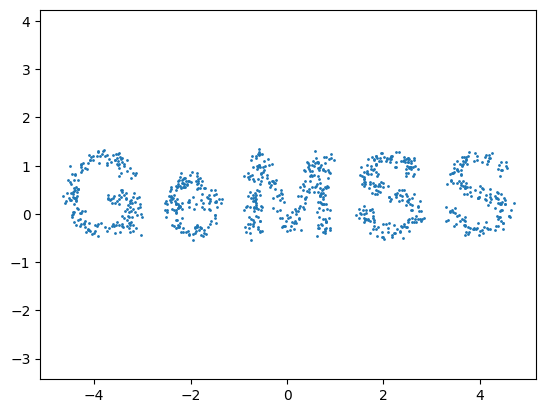

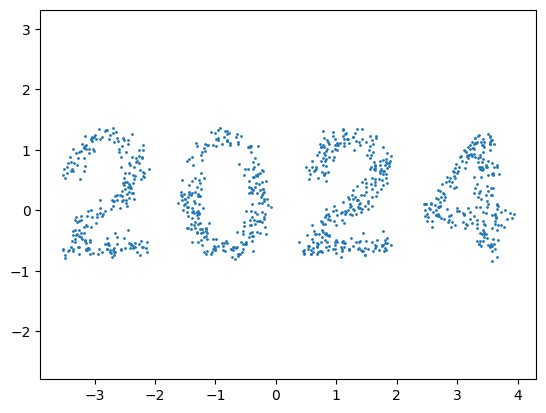

In [2]:
def sample_points_from_mask(mask, rng=None, num_samples=1000, sigma=0.05):
    # Get the indices of the pixels that are part of the letters
    letter_indices = np.argwhere(mask)

    # Uniformly sample points from these indices
    sampled_indices = letter_indices[np.random.choice(len(letter_indices), num_samples)]
    x = sampled_indices.astype(np.float32)
    x[:, 0] = -(x[:, 0] - mask.shape[0]/2) / (mask.shape[0]/8 )
    x[:, 1] = (x[:, 1] - mask.shape[1]/2) / (mask.shape[0]/8)
    x = np.flip(x,1)
    x = jnp.array(x) 
    x = x + sigma * jax.random.normal(rng, x.shape)
    return x


# Load the mask
gemss_mask = Image.open(r'gemss.png')
gemss_mask = np.array(gemss_mask)
gemss_mask = (gemss_mask==255)[:,:,0]

# Load the mask
year_mask = Image.open(r'2024.png')
year_mask = np.array(year_mask)
year_mask = (year_mask==255)[:,:,0]

key = jax.random.key(42)
key, rng1, rng2 = jax.random.split(key, 3)

gemss_samples = sample_points_from_mask(gemss_mask, rng1, num_samples=1000)
year_samples = sample_points_from_mask(year_mask, rng2, num_samples=1000)

def plot_x(xt_):
    plt.scatter(xt_[:,0],xt_[:,1],s=1)
    plt.axis('equal')
    plt.show()
    
plot_x(gemss_samples)

plot_x(year_samples)

# Model definition

In [3]:
class MLP(nn.Module):
    input_size: int
    hidden_size: int
    output_size: int
    num_layers: int
    use_scan: bool

    @nn.compact
    def __call__(self, x, t):
        x = jnp.concatenate([x, t], axis=1)
        for i in range(self.num_layers):
            x = nn.swish(nn.Dense(self.hidden_size, name=f"hidden_{i}")(x))
        x = nn.Dense(self.output_size)(x)
        return x
    

In [4]:
gemss_samples.shape

(1000, 2)

In [5]:
key, rng1, rng2 = jax.random.split(key, 3)
model = MLP(input_size=3, hidden_size=512, output_size=2, num_layers=5, use_scan=False)
params = model.init(rng1, gemss_samples, jax.random.normal(rng2, (1000, 1)))
optim = optax.adam(learning_rate=1e-3)

In [6]:
state = train_state.TrainState.create(
    apply_fn=model.apply,
    tx=optim,
    params=params["params"]
)

In [7]:
@jax.jit
def train_step(state: train_state.TrainState, x0: jnp.array, x1: jnp.array,  rng):
    key, rng1 = jax.random.split(rng, 2)
    def loss_fn(params):
        batch_size = x0.shape[0]
        t = jax.random.normal(rng1, (batch_size, 1))
    
        # compute conditional flow 
        # xt = psi_t(x0|x1) = sigma_t*x0 + alpha_t*x1
        xt = (1 - t) * x0 + t * x1
    
        # compute conditional velocity 
        # u_t(x|x1) = dsigma_t/dt*x0 + dalpha_t/dt*x1
        ut = x1 - x0
    
        # forward
        vt = state.apply_fn(dict(params=params), xt, t)
    
        # loss
        loss = jnp.square((vt - ut)).mean()
    
        return loss
    loss_fn_vmap = jax.vmap(loss_fn)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    loss_val, grads = loss_grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [8]:
n_iters = 5000
batch_size = 4000

In [9]:
for i in tqdm(range(n_iters)):
    key, rng1, rng2 = jax.random.split(key, 3)
    # sample x0~p
    x0 = sample_points_from_mask(gemss_mask, rng=rng1, num_samples=batch_size)
    # sample x1~q
    x1 = sample_points_from_mask(year_mask, rng=rng2, num_samples=batch_size)
    state = train_step(state, x0, x1, key)

100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.27it/s]


In [10]:
%%time
key, rng = jax.random.split(key, 2)
x0 = sample_points_from_mask(gemss_mask, rng=rng, num_samples=5000)
t = jnp.zeros((5000,1))

# number of discretization steps
N = 100
xt = x0
for i in range(N):
    xt = xt + state.apply_fn(dict(params=state.params), xt, t) * (1/N)
    t  = t + 1 / N

CPU times: user 1.37 s, sys: 125 ms, total: 1.5 s
Wall time: 1.39 s


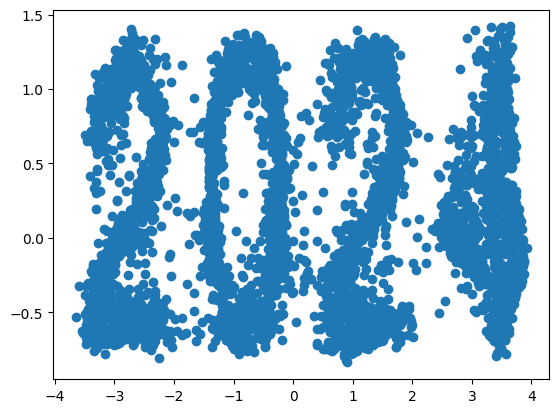

In [11]:
plt.scatter(np.array(xt[:,0]) , np.array(xt[:,1]))

In [12]:
key, rng = jax.random.split(key, 2)
x0 = sample_points_from_mask(gemss_mask, rng=rng, num_samples=5000)
t = jnp.zeros((5000,1))
xt = x0
stk = jnp.zeros((N, 5000, 2))

def sample(i, carry):
    xt, t, stk = carry
    xt_new = xt + state.apply_fn(dict(params=state.params), xt, t) * (1/N)
    t_new = t + (1 / N)
    stk = stk.at[i].set(xt_new)
    return (xt_new, t_new, stk)

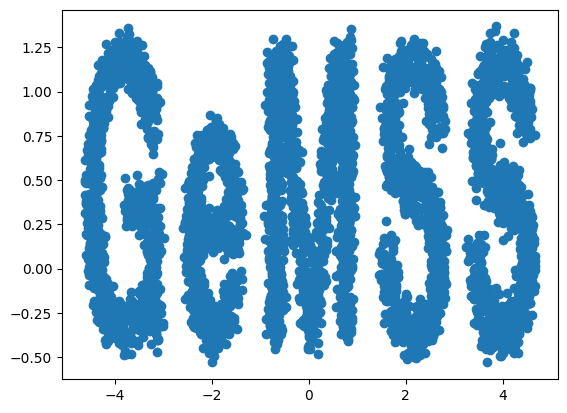

In [13]:
plt.scatter(np.array(xt[:,0]) , np.array(xt[:,1]))

In [14]:
%%time
carry = jax.lax.fori_loop(0, 100, sample, (xt, t, stk))

CPU times: user 61.2 ms, sys: 10.2 ms, total: 71.4 ms
Wall time: 77.9 ms


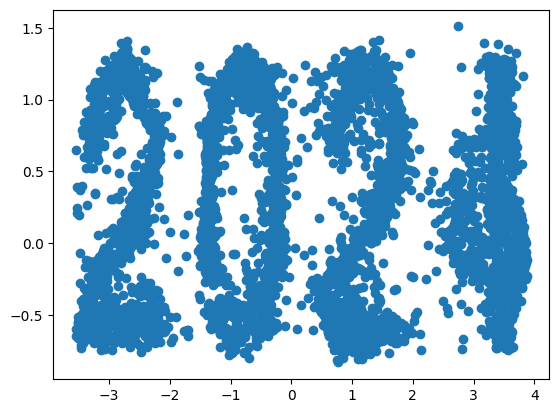

In [15]:
xtn = carry[0]
plt.scatter(np.array(xtn[:,0]) , np.array(xtn[:,1]))

In [ ]:
stk = carry[2]
stk = np.array(stk)

from IPython.display import HTML
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

fig, ax = plt.subplots()
def animate(i):
    ax.cla()
    ax.scatter(stk[i, :,0],stk[i, :,1],s=1)
    ax.set_xlim(-5,5)
    ax.set_ylim(-1,1.5)
    ax.axis('off')
    return fig
ani = animation.FuncAnimation(fig, animate, frames=100)
display(ani)